# 1. 门控循环单元GRU

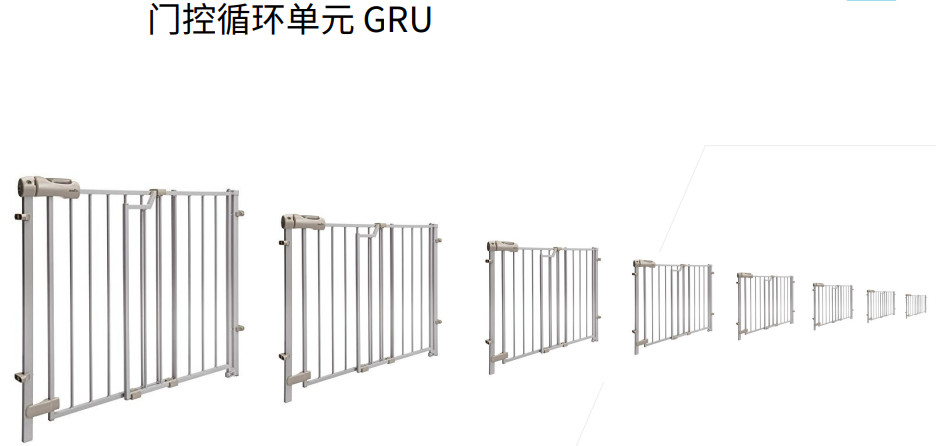

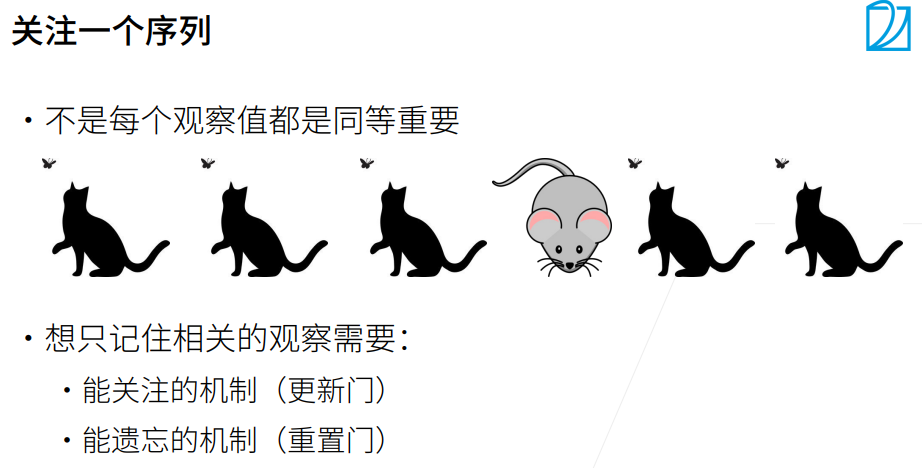

① 相当于全连接层把X和H并在一起。

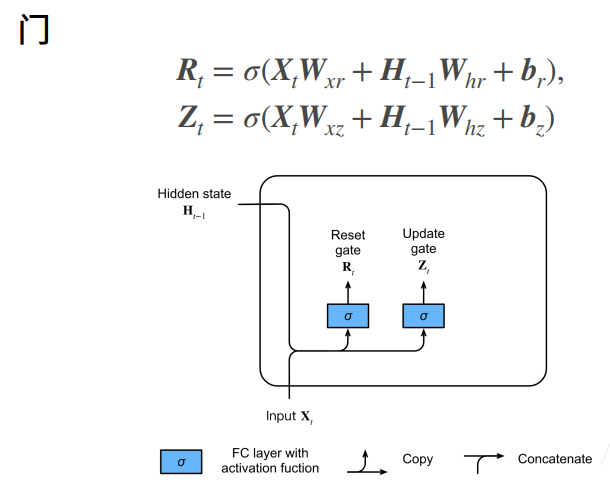

② 点圈是按元素乘法的意思。

③ $R_{t}$是可以学的，它可以根据前面的信息，看到这种情况知道哪些东西pass到下面的情况，哪些东西不pass到下面的情况。

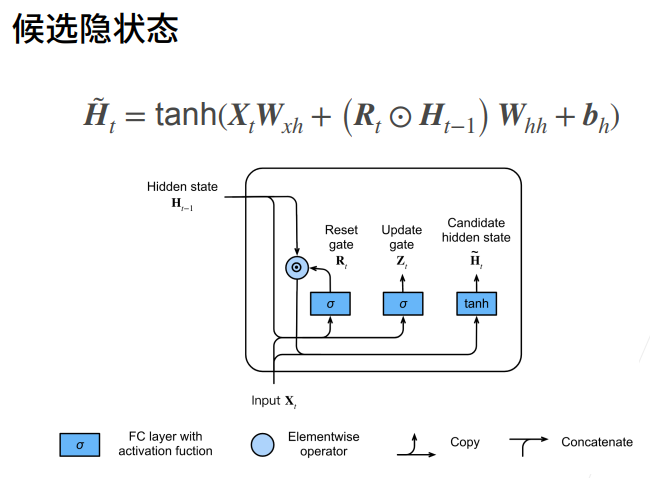

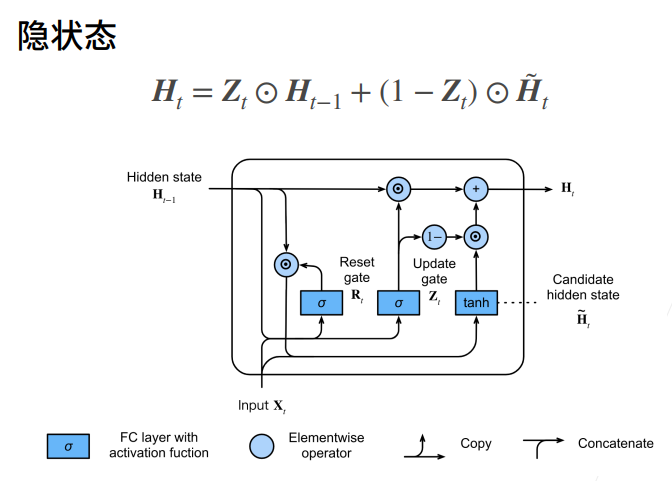

④ 更新新隐藏状态的时候，要用到多少过去隐藏状态的信息。

⑤ 若Z全0，R全1，则会回到RNN状态。

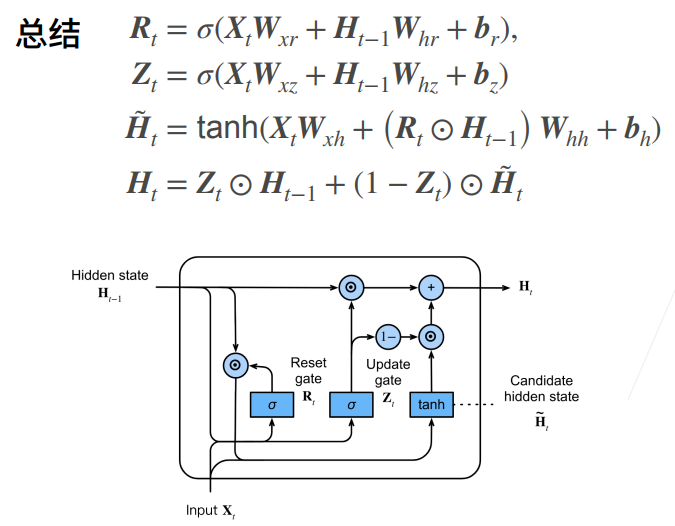

# 2. 门控循环单元GRU

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 设置每个batch的大小和时间步数
batch_size, num_steps = 32, 35
# 加载时间机器数据集并获取词汇表
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    # 设置输入和输出的维度为词汇表大小
    num_inputs = num_outputs = vocab_size
    
    # 定义一个函数，用于生成服从正态分布的随机张量，并乘以0.01进行缩放
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 定义一个函数，生成三组权重和偏置张量，用于不同的门控机制
    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    # 初始化GRU中的权重和偏置
    # 权重和偏置用于控制更新门
    W_xz, W_hz, b_z = three() # GRU多了这两行
    # 权重和偏置用于控制重置门
    W_xr, W_hr, b_r = three() # GRU多了这两行
    # 权重和偏置用于计算候选隐藏状态
    W_xh, W_hh, b_h = three()
    # 隐藏状态到输出的权重
    W_hq = normal((num_hiddens, num_outputs))
    # 输出的偏置
    b_q = torch.zeros(num_outputs, device=device)
    # 参数列表中各参数顺序
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    # 遍历参数列表中所有参数
    for param in params:
        # 设置参数的`requires_grad`属性为True，以便进行梯度计算
        param.requires_grad_(True)
    # 返回参数列表中所有参数
    return params

In [3]:
# 定义隐藏状态的初始化函数
def init_gru_state(batch_size, num_hiddens, device):
    # 返回隐藏状态初始化为全零的元组
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [4]:
# 定义门控循环单元模型
def gru(inputs, state, params):
    # 参数 params 解包为多个变量，分别表示模型中的权重和偏置
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params     
    # 传入的隐藏状态 state 解包为单个变量 H。
    H, = state
    # 创建一个空列表，用于存储每个时间步的输出
    outputs = []
    # 遍历输入序列中的每个时间步
    for X in inputs:
        # 更新门控机制 Z
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        # 重置门控机制 R
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        # 计算候选隐藏状态 H_tilda
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        # 更新隐藏状态 H
        H = Z * H + (1 - Z) * H_tilda
        # 计算输出 Y
        Y = H @ W_hq + b_q
        # 将输出添加到列表中
        outputs.append(Y)
    # 将所有输出拼接在一起，并返回拼接后的结果和最终的隐藏状态
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 29478.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


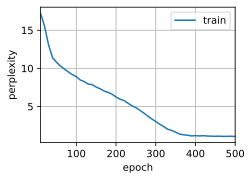

In [5]:
# 训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
# 设置训练的总轮数和学习率
num_epochs, lr = 500, 1
# 创建 GRU 模型实例
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                           init_gru_state, gru)
# 调用 D2L 库中的训练函数，传入模型实例、训练数据迭代器、词汇表、学习率和训练的总轮数
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 316122.5 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


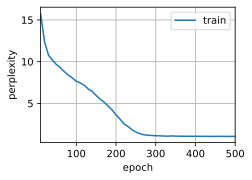

In [6]:
# 简洁实现
# 设置输入特征的维度为词汇表大小
num_inputs = vocab_size
# 创建一个 GRU 层，指定输入特征的维度和隐藏单元的数量
gru_layer = nn.GRU(num_inputs, num_hiddens)
# 创建一个 RNNModel 实例，传入 GRU 层和词汇表的大小
model = d2l.RNNModel(gru_layer, len(vocab))
# 将模型移动到指定的设备上（可能是 GPU）
model = model.to(device)
# 调用 D2L 库中的 train_ch8 函数进行训练，传入模型实例、训练数据迭代器、词汇表、学习率和训练的总轮数
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)